In [ ]:
pip install newsapi-python

In [2]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import re

class DrugInfoExtractor:
    def __init__(self, api_key):
        self.api_key = api_key
        self.base_url = "https://newsapi.org/v2/everything"

    def extract_drug_information(self):
        search_terms = [
            "cancer drug", "cancer treatment", "cancer therapy",
            "oncology medicine", "cancer medicine", "chemotherapy",
            "targeted therapy cancer", "immunotherapy cancer"
        ]

        end_date = datetime.now()
        start_date = end_date - timedelta(days=31)

        all_drug_data = []

        for search_term in search_terms:
            params = {
                "q": search_term,
                "from": start_date.strftime('%Y-%m-%d'),
                "to": end_date.strftime('%Y-%m-%d'),
                "language": "en",
                "sortBy": "relevancy",
                "pageSize": 100,
                "apiKey": self.api_key
            }

            response = requests.get(self.base_url, params=params)
            if response.status_code != 200:
                print(f"Error fetching news for {search_term}: {response.json()}")
                continue

            articles = response.json().get("articles", [])

            for article in articles:
                # Handle potential None values with empty string defaults
                title = article.get("title", "") or ""
                description = article.get("description", "") or ""
                source_name = article.get("source", {}).get("name", "Unknown")
                url = article.get("url", "")

                # Combine text for analysis, ensuring both are strings
                combined_text = f"{title} {description}"

                # Extract drug names using pattern matching
                drug_pattern = r"(?i)([\w-]+(?:mab|nib|zomib|tinib|ciclib|lisib|toclax|parib|rafenib|metinib|cedinib|rutinib))"
                found_drugs = re.findall(drug_pattern, combined_text)

                # Extract cancer types
                cancer_types = self._extract_cancer_type(combined_text)

                if found_drugs:
                    for drug in found_drugs:
                        drug_info = {
                            "Source": source_name,
                            "Drug Name": drug.capitalize(),
                            "Description": description[:500] if description else "No description available",
                            "Cancer Type": cancer_types if cancer_types else "Not specified",
                            "URL": url
                        }
                        # Avoid duplicates
                        if not any(d["Drug Name"] == drug_info["Drug Name"] and
                                 d["Source"] == drug_info["Source"] for d in all_drug_data):
                            all_drug_data.append(drug_info)

        return all_drug_data[:50]  # Return top 50 unique entries

    def _extract_cancer_type(self, text):
        if not text:
            return "Not specified"

        cancer_patterns = [
            r"(?i)(breast cancer|lung cancer|prostate cancer|colorectal cancer|melanoma|leukemia|lymphoma|pancreatic cancer|ovarian cancer|brain cancer|glioblastoma|multiple myeloma)"
        ]

        for pattern in cancer_patterns:
            matches = re.findall(pattern, text)
            if matches:
                return ", ".join(set(match.title() for match in matches))
        return "Not specified"

    def save_json(self, data, filename="drug_data.json"):
        with open(filename, "w", encoding="utf-8") as f:
            json.dump(data, f, indent=4, ensure_ascii=False)
        print(f"\nJSON data saved to {filename}")

    def save_to_csv(self, data, filename="drug_data.csv"):
        df = pd.DataFrame(data)
        df.to_csv(filename, index=False, encoding='utf-8')
        print(f"\nCSV data saved to {filename}")

    def display_results(self, data):
        if not data:
            print("No results found.")
            return pd.DataFrame()

        print("\nJSON Format Sample (First 5 records):")
        print(json.dumps(data[:5], indent=4, ensure_ascii=False))

        print("\nDataFrame Format:")
        df = pd.DataFrame(data)
        print(df.to_string())
        return df

if __name__ == "__main__":
    extractor = DrugInfoExtractor(api_key="028a2be0ee3b48dea36efaf5bfe35003")
    drug_data = extractor.extract_drug_information()

    if drug_data:
        # Save and display results
        extractor.save_json(drug_data)
        extractor.save_to_csv(drug_data)
        df = extractor.display_results(drug_data)


JSON data saved to drug_data.json

CSV data saved to drug_data.csv

JSON Format Sample (First 5 records):
[
    {
        "Source": "Science Daily",
        "Drug Name": "Encorafenib",
        "Description": "Patients with metastatic colorectal cancer (mCRC) harboring BRAF V600E mutations benefited from first-line treatment with the targeted therapies encorafenib and cetuximab plus a mFOLFOX6 chemotherapy regimen, according to results from the PhaseIII BREAKWATER …",
        "Cancer Type": "Colorectal Cancer",
        "URL": "https://www.sciencedaily.com/releases/2025/01/250125152749.htm"
    },
    {
        "Source": "Science Daily",
        "Drug Name": "Cetuximab",
        "Description": "Patients with metastatic colorectal cancer (mCRC) harboring BRAF V600E mutations benefited from first-line treatment with the targeted therapies encorafenib and cetuximab plus a mFOLFOX6 chemotherapy regimen, according to results from the PhaseIII BREAKWATER …",
        "Cancer Type": "Colorectal

In [8]:
df.head()

,Source,Drug Name,Description,Cancer Type,URL
0,Science Daily,encorafenib,Patients with metastatic colorectal cancer (mC...,colorectal cancer,https://www.sciencedaily.com/releases/2025/01/...
1,Science Daily,cetuximab,Patients with metastatic colorectal cancer (mC...,colorectal cancer,https://www.sciencedaily.com/releases/2025/01/...
2,NPR,consumab,Recreational marijuana is still illegal in Tex...,not specified,https://www.npr.org/2025/01/10/nx-s1-5220336/d...
3,Yahoo Entertainment,datopotamab,"On Friday, the U.S. Food and Drug Administrati...",breast cancer,https://finance.yahoo.com/news/fda-approves-as...
4,FDA.gov,acalabrutinib,"On January 16, 2025, the FDA granted tradition...",lymphoma,https://www.fda.gov/drugs/resources-informatio...


In [4]:
df.shape

(15, 5)

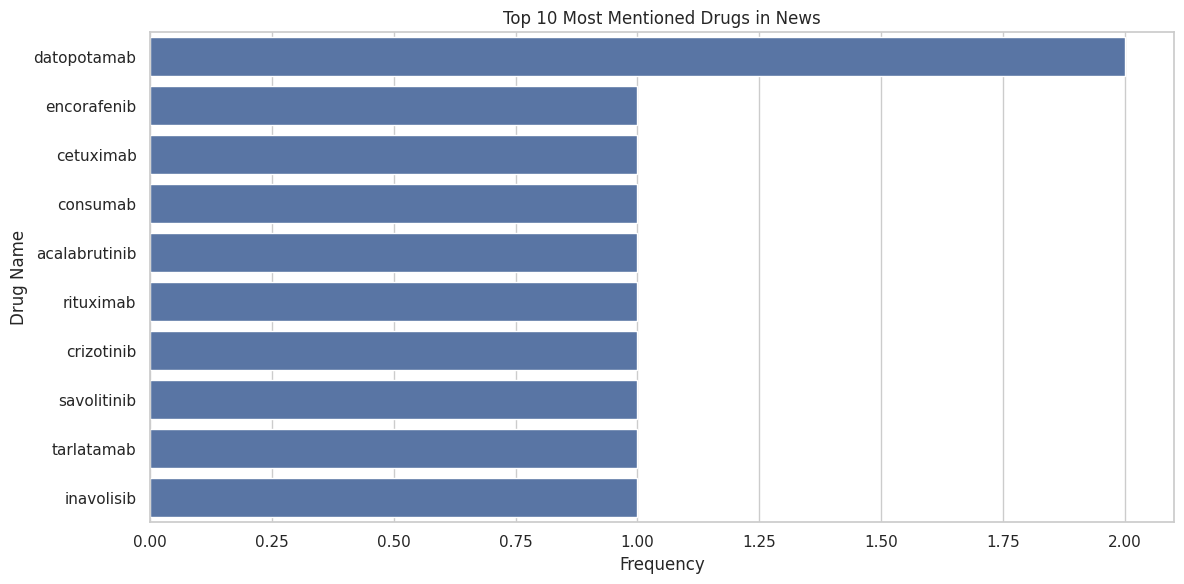

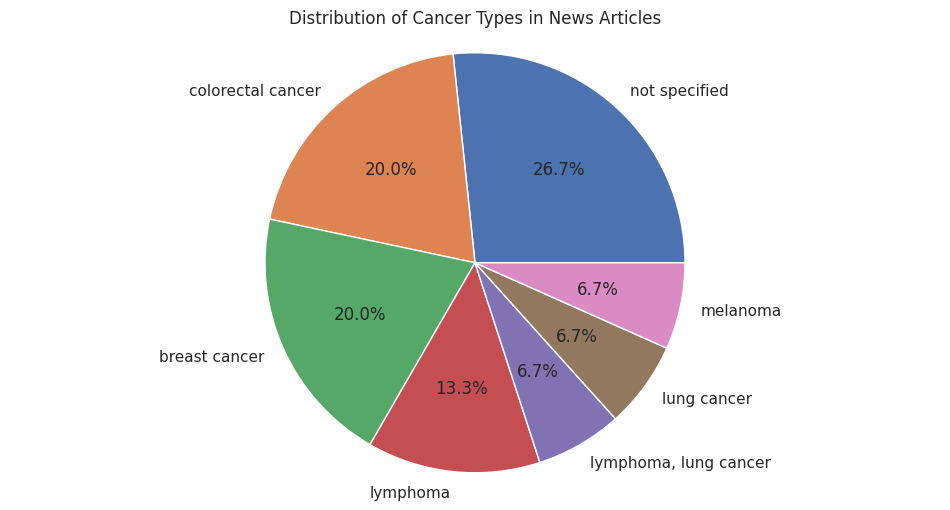

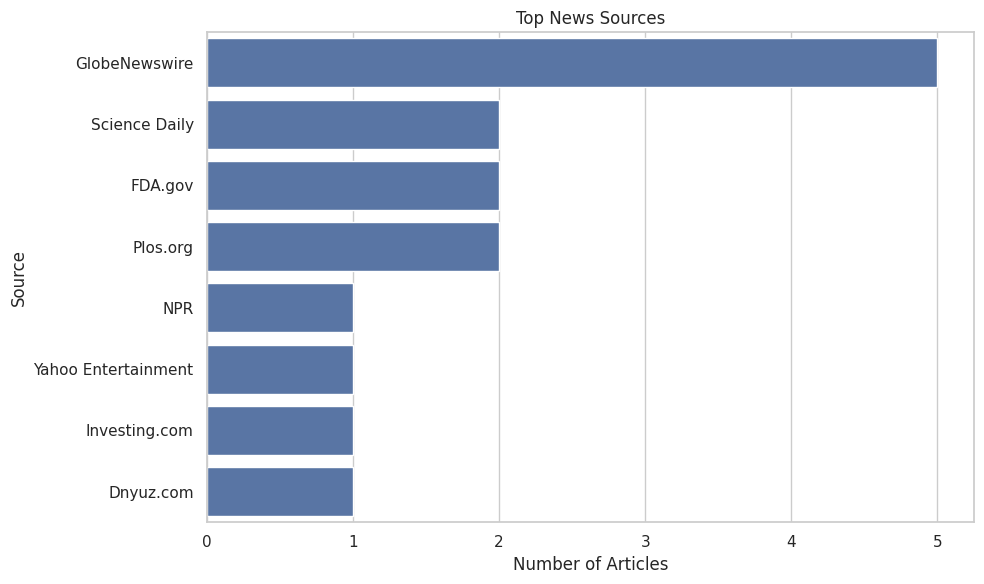

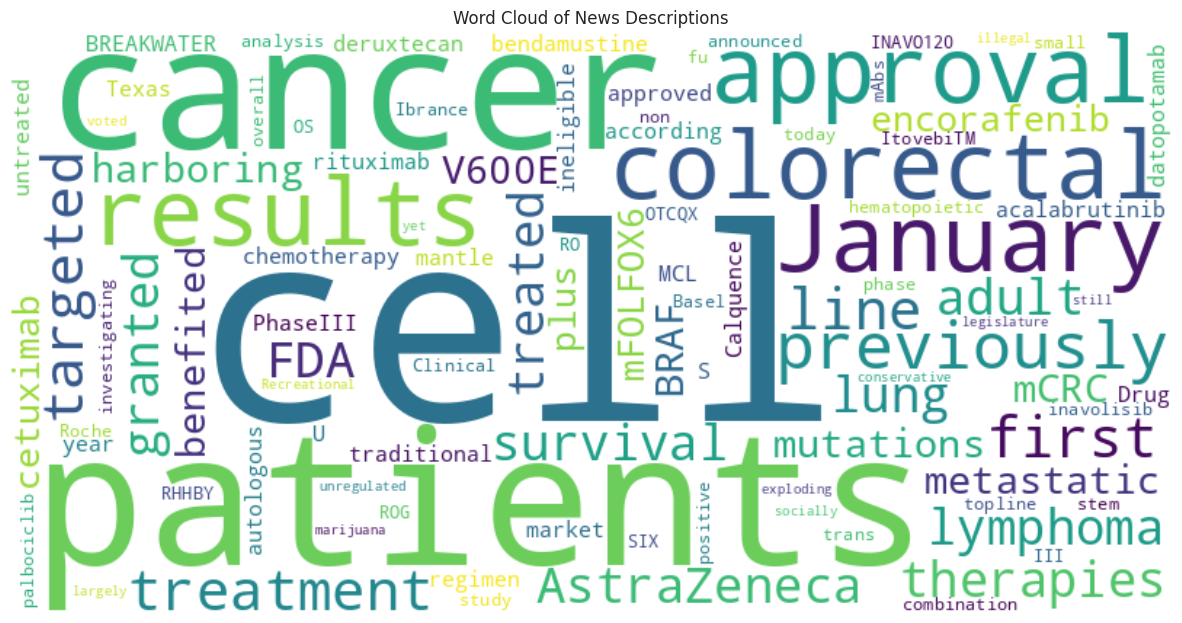


Cleaned news data saved to 'cleaned_news_data.csv'

Sample of cleaned news data:
                Source      Drug Name  \
0        Science Daily    encorafenib   
1        Science Daily      cetuximab   
2                  NPR       consumab   
3  Yahoo Entertainment    datopotamab   
4              FDA.gov  acalabrutinib   

                                         Description        Cancer Type  \
0  Patients with metastatic colorectal cancer (mC...  colorectal cancer   
1  Patients with metastatic colorectal cancer (mC...  colorectal cancer   
2  Recreational marijuana is still illegal in Tex...      not specified   
3  On Friday, the U.S. Food and Drug Administrati...      breast cancer   
4  On January 16, 2025, the FDA granted tradition...           lymphoma   

                                                 URL  
0  https://www.sciencedaily.com/releases/2025/01/...  
1  https://www.sciencedaily.com/releases/2025/01/...  
2  https://www.npr.org/2025/01/10/nx-s1-5220336/d...  


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Set seaborn style correctly
sns.set_theme(style="whitegrid")

# Data Cleaning
# Clean drug names by removing special characters and standardizing format
df['Drug Name'] = df['Drug Name'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x).strip().lower())

# Standardize cancer types
df['Cancer Type'] = df['Cancer Type'].fillna('Not specified')
df['Cancer Type'] = df['Cancer Type'].str.lower()

# Remove duplicates
df = df.drop_duplicates(subset=['Drug Name', 'Source', 'Description'])

# 1. Drug Frequency Analysis
plt.figure(figsize=(12, 6))
drug_counts = df['Drug Name'].value_counts().head(10)
sns.barplot(data=pd.DataFrame({'Drug': drug_counts.index, 'Count': drug_counts.values}),
            x='Count', y='Drug')
plt.title('Top 10 Most Mentioned Drugs in News')
plt.xlabel('Frequency')
plt.ylabel('Drug Name')
plt.tight_layout()
plt.savefig('drug_frequency.png')
plt.show()

# 2. Cancer Type Distribution
plt.figure(figsize=(12, 6))
cancer_counts = df['Cancer Type'].value_counts()
plt.pie(cancer_counts.values, labels=cancer_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Cancer Types in News Articles')
plt.axis('equal')
plt.savefig('cancer_distribution.png')
plt.show()

# 3. Source Analysis
plt.figure(figsize=(10, 6))
source_counts = df['Source'].value_counts().head(8)
sns.barplot(data=pd.DataFrame({'Source': source_counts.index, 'Count': source_counts.values}),
            x='Count', y='Source')
plt.title('Top News Sources')
plt.xlabel('Number of Articles')
plt.tight_layout()
plt.savefig('source_analysis.png')
plt.show()

# Additional analysis - Create word cloud of descriptions
# Combine all descriptions
text = ' '.join(df['Description'].dropna())

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     max_words=100,
                     collocations=False).generate(text)

# Display the word cloud
plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Descriptions')
plt.savefig('wordcloud.png')
plt.show()

# Save cleaned data
df.to_csv('cleaned_news_data.csv', index=False)
print("\nCleaned news data saved to 'cleaned_news_data.csv'")

# Display sample of cleaned data
print("\nSample of cleaned news data:")
print(df.head())

# Basic statistics
print("\nBasic statistics of the news dataset:")
print(f"Total number of articles: {len(df)}")
print(f"Number of unique sources: {df['Source'].nunique()}")
print(f"Number of unique drugs: {df['Drug Name'].nunique()}")
print(f"Number of unique cancer types: {df['Cancer Type'].nunique()}")